In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from scipy.stats import kurtosis
from sklearn.datasets import load_breast_cancer
from scipy import linalg

from kneed import KneeLocator
from sklearn.metrics import silhouette_score, v_measure_score,homogeneity_score,adjusted_rand_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Data Loading

In [2]:
data = load_breast_cancer().data
labels = load_breast_cancer().target

# k-means clustering

In [3]:
#How did we choose k?
#We chose k=10 by running SSE and Silhouette Score to calculate 
#mean intra-cluster distance (a) and the mean 
#nearest-cluster distance (b) for each sample
#chose lowest SSE and highest silhouette score

In [4]:
def kMeansDataGenerator(data, typeOfAlgorithm):
    kmeans_kwargs_random = {
       "init": "random",
       "n_init": 10,
       "max_iter": 300,
       "random_state": 42
    }

    kmeans_kwargs_pp = {
       "init": "k-means++",
       "n_init": 10,
       "max_iter": 300,
       "random_state": 42
    }
    
    randomVM = []
    kMeansPPVM = []

    randomHS = []
    kmeansPPHS=[]

    randomCS = []
    kmeansPPCS = []
    
    sseRandom = []
    ssePP = []

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs_random)
        pred = kmeans.fit(data)
        kmeans.fit(data)
        randomVM.append(v_measure_score(labels, pred.predict(data)))
        randomHS.append(homogeneity_score(labels, pred.predict(data)))
        randomCS.append(adjusted_rand_score(labels, pred.predict(data)))
        sseRandom.append(kmeans.inertia_)
        
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs_pp)
        pred = kmeans.fit(data)
        kmeans.fit(data)
        kMeansPPVM.append(v_measure_score(labels, pred.predict(data)))
        kmeansPPHS.append(homogeneity_score(labels, pred.predict(data)))
        kmeansPPCS.append(adjusted_rand_score(labels, pred.predict(data)))
        ssePP.append(kmeans.inertia_)
        
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), randomVM,label='Random')
    plt.plot(range(1, 11), kMeansPPVM,label='KMeans++')
    plt.xticks(range(1, 11))
    plt.yticks(np.arange(0,1.1,.1))
    plt.xlabel("Number of Clusters")
    plt.ylabel("V-measure cluster score")
    plt.legend()
    plt.title(f'''{typeOfAlgorithm} V-measure cluster score''')
    plt.show()
    print(f'''Max V-Measure is {max(max(randomVM),max(kMeansPPVM))}''')
    
    
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), randomHS,label='Random')
    plt.plot(range(1, 11), kmeansPPHS,label='KMeans++')
    plt.xticks(range(1, 11))
    plt.yticks(np.arange(0,1.1,.1))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Homogeneity Score")
    plt.legend()
    plt.title(f'''{typeOfAlgorithm} Homogeneity Score''')
    plt.show()
    print(f'''Max Homogeneity Score is {max(max(randomHS),max(kmeansPPHS))}''')
    
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), randomCS,label='Random')
    plt.plot(range(1, 11), kmeansPPCS,label='KMeans++')
    plt.xticks(range(1, 11))
    plt.yticks(np.arange(0,1.1,.1))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Adjusted Random Score")
    plt.legend()
    plt.title(f'''{typeOfAlgorithm} Adjusted Random Score''')
    plt.show()
    print(f'''Max Adjusted Random Score is {max(max(randomCS),max(kmeansPPCS))}''')
    
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sseRandom, label = 'Random')
    plt.plot(range(1, 11), ssePP, label = 'KMeans++')
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum Squared Errors")
    plt.title(f'''{typeOfAlgorithm} SSE''')
    plt.legend()
    plt.show()
    
    return None

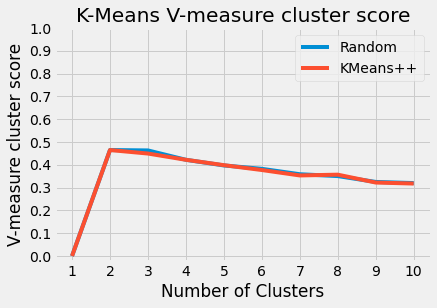

Max V-Measure is 0.46479332792160805


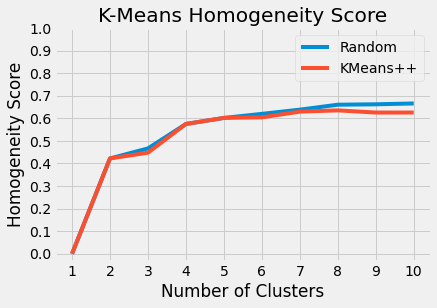

Max Homogeneity Score is 0.6658469917463671


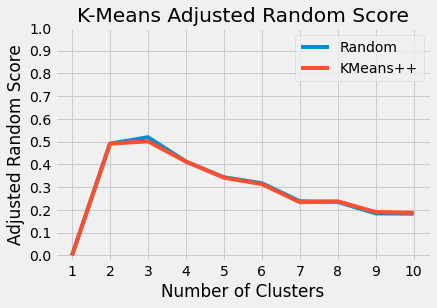

Max Adjusted Random Score is 0.5197881128908282


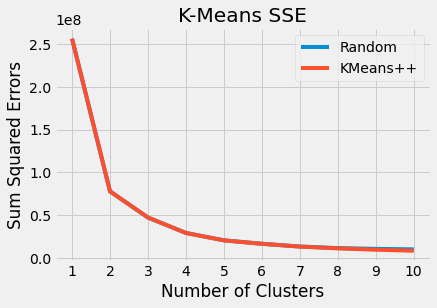

In [5]:
kMeansDataGenerator(data,'K-Means')

# Expectation Maximization

In [6]:
#Describe clusters

In [7]:
def gaussianMixtureDataGenerator(data, typeOfAlgorithm):
    GM_Spherical = {
       'covariance_type' : 'spherical',
       "max_iter": 20,
       "random_state": 42
    }
    
    GM_Diag = {
       'covariance_type' : 'diag',
       "max_iter": 20,
       "random_state": 42
    }
    
    GM_Tied = {
       'covariance_type' : 'tied',
       "max_iter": 20,
       "random_state": 42
    }

    GM_Full = {
       'covariance_type' : 'full',
       "max_iter": 20,
       "random_state": 42
    }
    
    sphereVM = []
    diagVM = []
    tiedVM = []
    fullVM = []
    
    
    sphereHS = []
    diagHS = []
    tiedHS = []
    fullHS = []

    sphereAIC = []
    diagAIC = []
    tiedAIC = []
    fullAIC = []
    
    sphereBIC = []
    diagBIC = []
    tiedBIC = []
    fullBIC = []

    for n in range(1, 11):
        gmm = GaussianMixture(n_components=n,**GM_Spherical)
        pred = gmm.fit(data)
        sphereVM.append(v_measure_score(labels, pred.predict(data)))
        sphereHS.append(homogeneity_score(labels, pred.predict(data)))
        sphereAIC.append(gmm.aic(data))
        sphereBIC.append(gmm.bic(data))
        
        gmm = GaussianMixture(n_components=n,**GM_Diag)
        pred = gmm.fit(data)
        diagVM.append(v_measure_score(labels, pred.predict(data)))
        diagHS.append(homogeneity_score(labels, pred.predict(data)))
        diagAIC.append(gmm.aic(data))
        diagBIC.append(gmm.bic(data))
        
        gmm = GaussianMixture(n_components=n,**GM_Tied)
        pred = gmm.fit(data)
        tiedVM.append(v_measure_score(labels, pred.predict(data)))
        tiedHS.append(homogeneity_score(labels, pred.predict(data)))
        tiedAIC.append(gmm.aic(data))
        tiedBIC.append(gmm.bic(data))
        
        gmm = GaussianMixture(n_components=n,**GM_Full)
        pred = gmm.fit(data)
        fullVM.append(v_measure_score(labels, pred.predict(data)))
        fullHS.append(homogeneity_score(labels, pred.predict(data)))
        fullAIC.append(gmm.aic(data))
        fullBIC.append(gmm.bic(data))
    #Plot AIC    
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sphereAIC,label='Sphere')
    plt.plot(range(1, 11), diagAIC,label='Diagonal')
    plt.plot(range(1, 11), tiedAIC,label='Tied')
    plt.plot(range(1, 11), fullAIC,label='Full')    
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("AIC")
    plt.legend()
    plt.title(f'''{typeOfAlgorithm} AIC''')
    plt.show()
    
    #Plot BIC
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sphereBIC ,label='Sphere')
    plt.plot(range(1, 11), diagBIC ,label='Diagonal')
    plt.plot(range(1, 11), tiedBIC ,label='Tied')
    plt.plot(range(1, 11), fullBIC ,label='Full')    
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("BIC")
    plt.legend()
    plt.title(f'''{typeOfAlgorithm} BIC''')
    plt.show()
    
    #Plot HS
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sphereHS  ,label='Sphere')
    plt.plot(range(1, 11), diagHS  ,label='Diagonal')
    plt.plot(range(1, 11), tiedHS  ,label='Tied')
    plt.plot(range(1, 11), fullHS  ,label='Full')    
    plt.xticks(range(1, 11))
    plt.yticks(np.arange(0,1.1,.1))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Homogeneity Score")
    plt.legend()
    plt.title(f'''{typeOfAlgorithm} Homogeneity Score''')
    plt.show()    
    
    #Plot VM
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sphereVM   ,label='Sphere')
    plt.plot(range(1, 11), diagVM   ,label='Diagonal')
    plt.plot(range(1, 11), tiedVM   ,label='Tied')
    plt.plot(range(1, 11), fullVM   ,label='Full')    
    plt.xticks(range(1, 11))
    plt.yticks(np.arange(0,1.1,.1))
    plt.xlabel("Number of Clusters")
    plt.ylabel("V-measure cluster score")
    plt.legend()
    plt.title(f'''{typeOfAlgorithm} V-measure cluster score''')
    plt.show()
    return None

C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase 

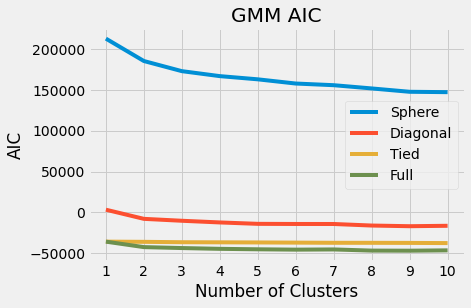

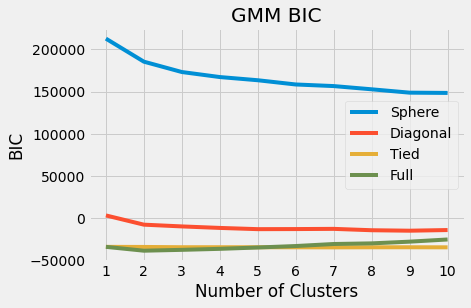

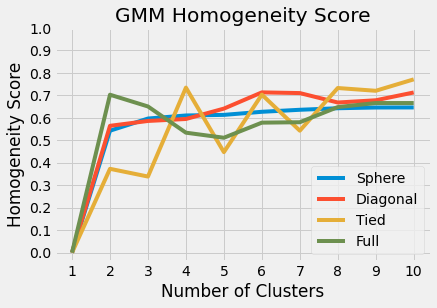

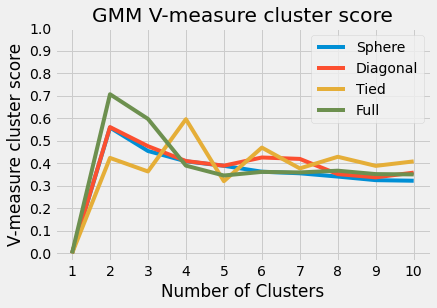

In [8]:
gaussianMixtureDataGenerator(data, "GMM")

# Dimensionality Reduction

## PCA

No handles with labels found to put in legend.


[0.98204467 0.99822116 0.99977867 0.9998996  0.99998788 0.99999453
 0.99999854 0.99999936 0.99999971 0.99999989 0.99999996 0.99999998
 0.99999999 0.99999999 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


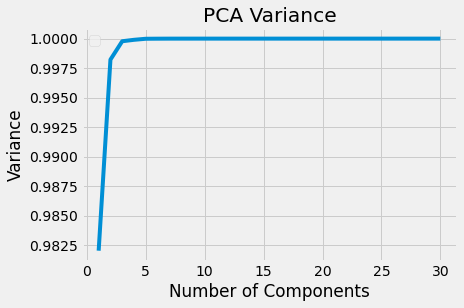

In [30]:
#what is the distribution of eigenvalues
#how well is the data reconstructed by PCA?
def runPCA(data,algType):
    variances = []
    pca = PCA().fit(data)
    print(np.cumsum(pca.explained_variance_ratio_))
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 31),np.cumsum(pca.explained_variance_ratio_))   
    plt.xlabel("Number of Components")
    plt.ylabel("Variance")
    plt.legend()
    plt.title(f'''{algType}''')
    plt.show()
    return None
    
runPCA(data,"PCA Variance")

## ICA

C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


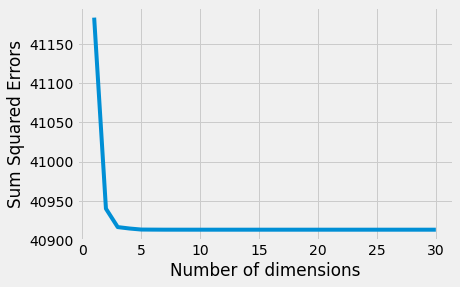

In [10]:
#how kurtotic are the distributions? Do the projection axes for ICA seem to capture anything "meaningful"?
#how well is the data reconstructed by PCA?
def runICA(data,title):
    rc_errors = {}
    for dim in range(1,31):
        ica = FastICA(n_components=dim, random_state=42)
        x_prime = ica.fit_transform(data)

        # reconstruction
        A = np.linalg.pinv(ica.components_.T)
        reconstructed = np.dot(x_prime, A)
        rc_err = mean_squared_error(data, reconstructed)    
        rc_errors[dim] = rc_err
    #     print(dim, ": ", rc_err)
    plt.figure()
    plt.plot(list(rc_errors.keys()), list(rc_errors.values()))
    plt.xlabel("Number of dimensions")
    plt.ylabel("Sum Squared Errors")
    plt.show()
    return None

runICA(data,'none')

## Random Projection (Gaussian)

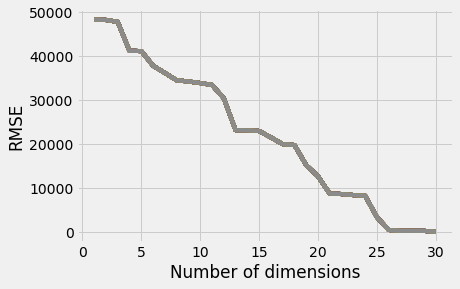

In [11]:
#how well is the data reconstructed by the randomized projections
#How much variation did you get when you re-ran your RP several times
def runRP(data,title):
    plt.figure()
    for i in range(65): 
        rc_errors = {}
        for dim in range(1,31):
            grp = GaussianRandomProjection(n_components=dim, random_state=44)
            x_prime = grp.fit_transform(data)

            # reconstruction
            A = np.linalg.pinv(grp.components_.T)
            reconstructed = np.dot(x_prime, A)
            rc_err = mean_squared_error(data, reconstructed)    
            rc_errors[dim] = rc_err
        plt.plot(list(rc_errors.keys()), list(rc_errors.values()),label = i)   

    plt.xlabel("Number of dimensions")
    plt.ylabel("RMSE")
    plt.show()
    return None
    
runRP(data,'Title')

## VarianceThreshold

No handles with labels found to put in legend.


[0.97440781 0.99609644 0.99872706 0.99989034 0.9999817  0.99999444
 0.99999849 0.99999931 0.99999969 0.99999988 0.99999996 0.99999998
 0.99999999 0.99999999 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


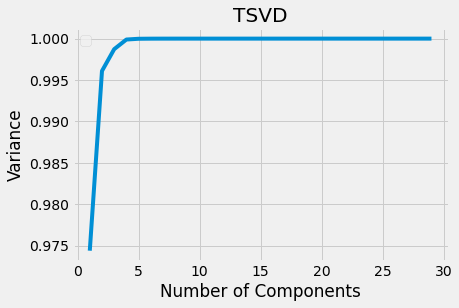

In [12]:
def runTSVD(data,algType):
    variances = []
    TSVD = TruncatedSVD(29).fit(data)
    print(np.cumsum(TSVD.explained_variance_ratio_))
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 30),np.cumsum(TSVD.explained_variance_ratio_))   
    plt.xlabel("Number of Components")
    plt.ylabel("Variance")
    plt.legend()
    plt.title(f'''{algType}''')
    plt.show()
    return None
    
runTSVD(data,"TSVD")

# Kmeans with Dimensionality Reduction

In [13]:
#How did we choose k?
#When you reproduced your clustering experiments on the datasets projected onto the new spaces created by ICA, PCA, and RP, 
#did you get the same clusters as before? Different clusters? Why? Why not?

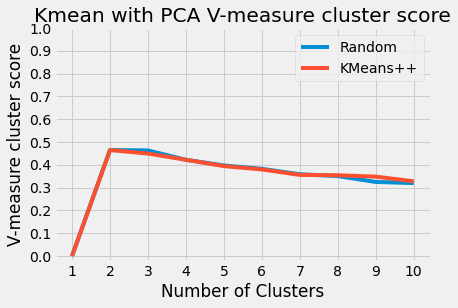

Max V-Measure is 0.46479332792160805


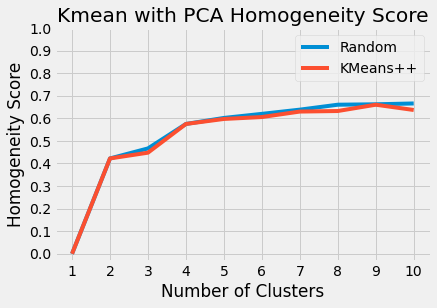

Max Homogeneity Score is 0.6658469917463671


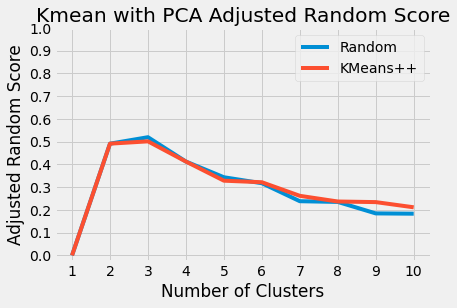

Max Adjusted Random Score is 0.5197881128908282


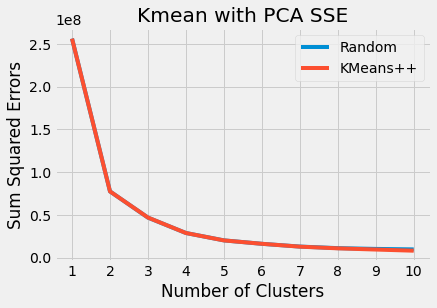

In [31]:
#PCA
pca = PCA(2).fit_transform(data)
kMeansDataGenerator(pca,'Kmean with PCA')

In [32]:
#ICA

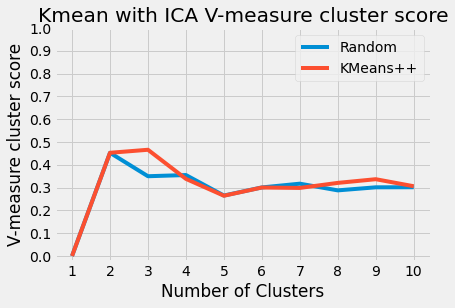

Max V-Measure is 0.46595071889796885


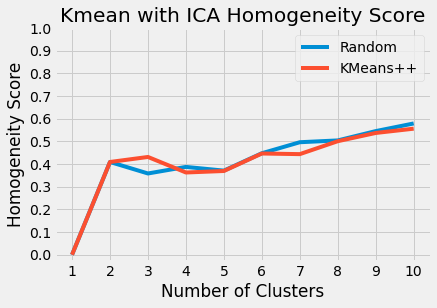

Max Homogeneity Score is 0.5790940953438153


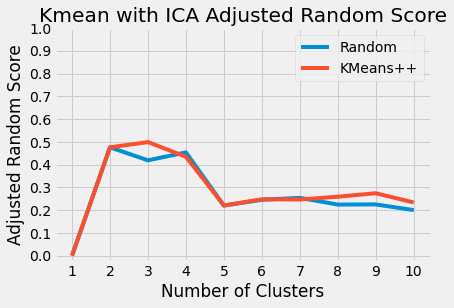

Max Adjusted Random Score is 0.4987328779079085


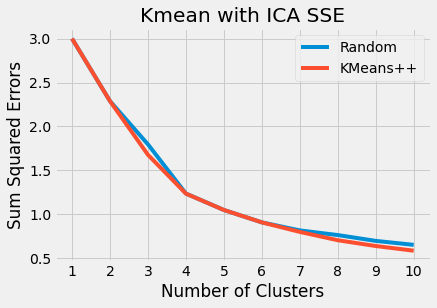

In [33]:
ica = FastICA(n_components=3, random_state=42)
x_prime = ica.fit_transform(data)
kMeansDataGenerator(x_prime,'Kmean with ICA')

In [34]:
#Random Projection

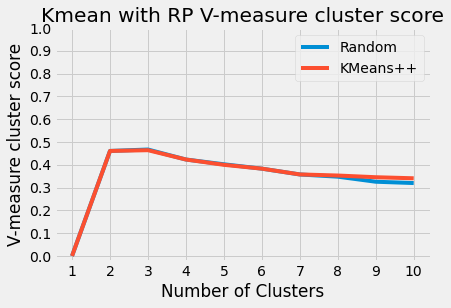

Max V-Measure is 0.4670134389489123


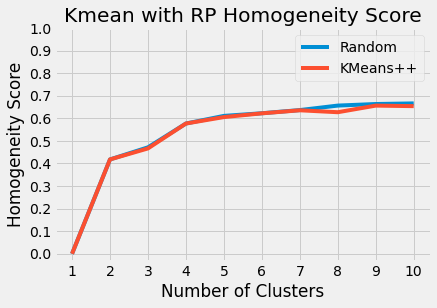

Max Homogeneity Score is 0.6660847615959364


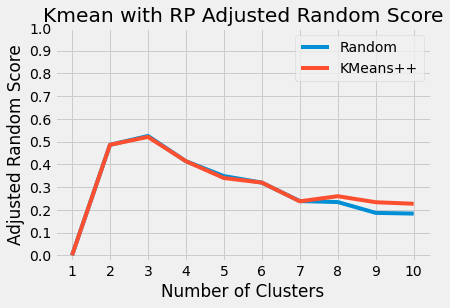

Max Adjusted Random Score is 0.5249818441596507


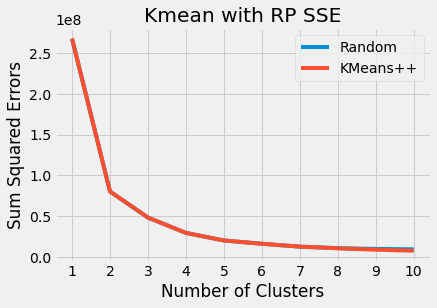

In [35]:
grp = GaussianRandomProjection(n_components=20, random_state=44)
x_prime = grp.fit_transform(data)
kMeansDataGenerator(x_prime,'Kmean with RP')

In [36]:
#TSVD

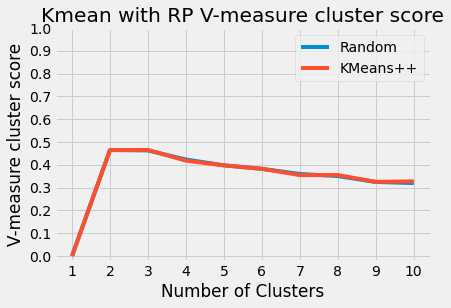

Max V-Measure is 0.46519535556883285


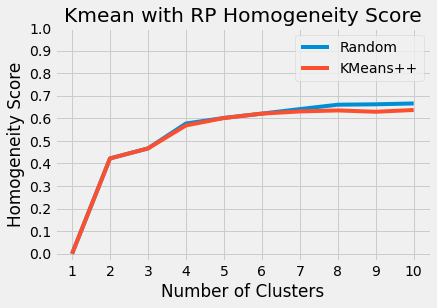

Max Homogeneity Score is 0.6658469917463671


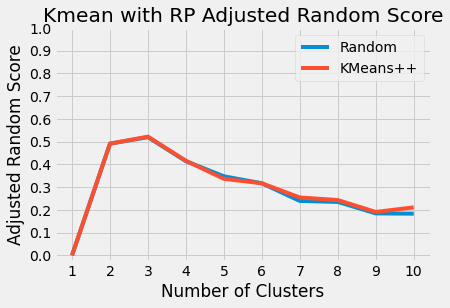

Max Adjusted Random Score is 0.5222179597264479


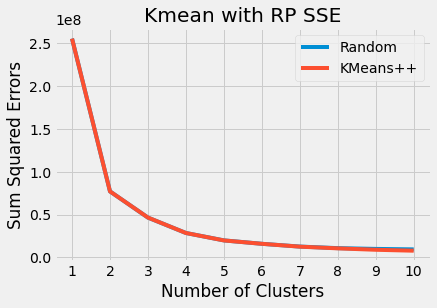

In [37]:
tsvd = TruncatedSVD(2).fit_transform(data)
kMeansDataGenerator(tsvd,'Kmean with RP')

# Expectation Maximization with Dimensionality Reduction

In [38]:
#When you reproduced your clustering experiments on the datasets projected onto the new spaces created by ICA, PCA, and RP, 
#did you get the same clusters as before? Different clusters? Why? Why not?

In [39]:
#PCA

C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase 

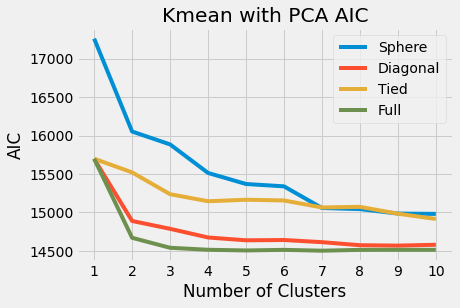

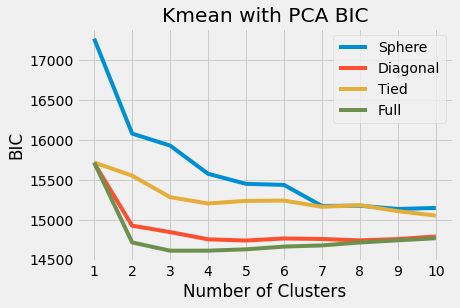

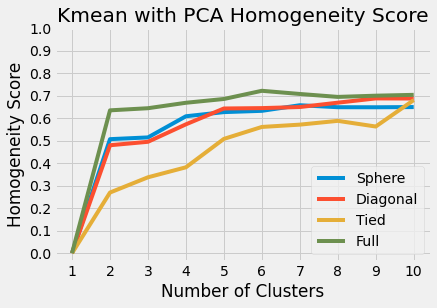

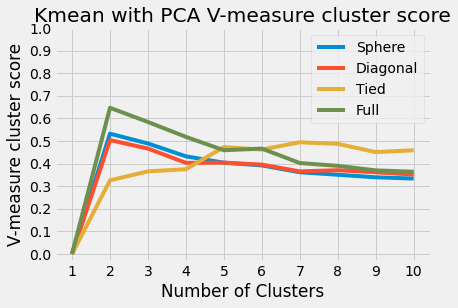

In [40]:
pca = PCA(2).fit_transform(data)
gaussianMixtureDataGenerator(pca,'Kmean with PCA')

In [41]:
#ICA

C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase 

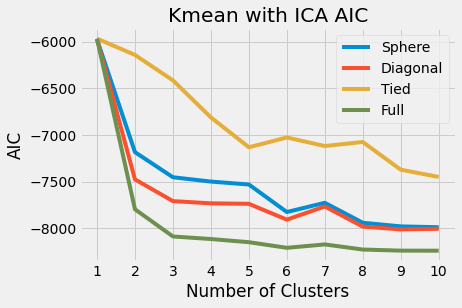

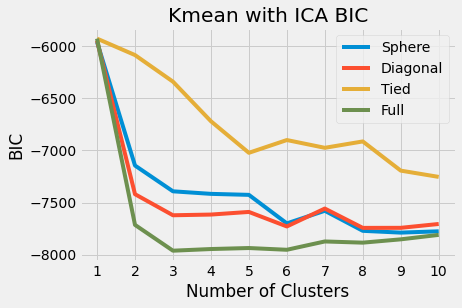

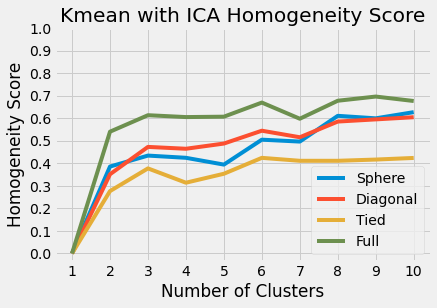

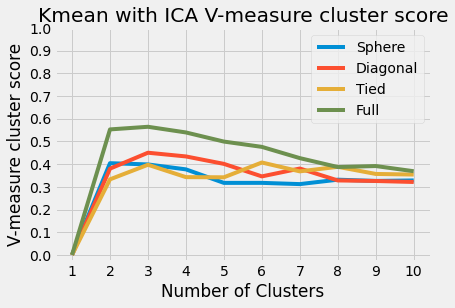

In [42]:
ica = FastICA(n_components=3, random_state=42)
x_prime = ica.fit_transform(data)
gaussianMixtureDataGenerator(x_prime,'Kmean with ICA')

In [43]:
#Random Projection

C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase 

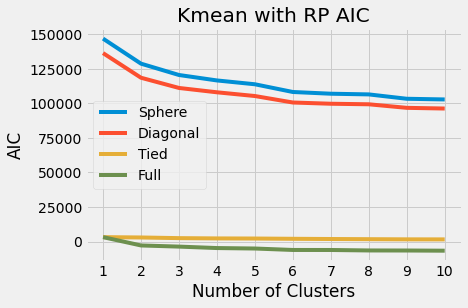

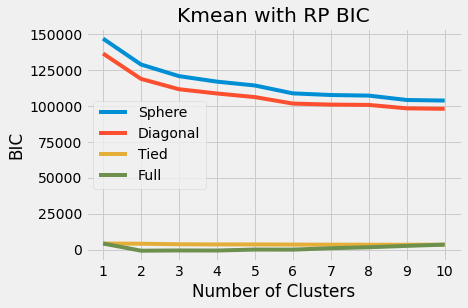

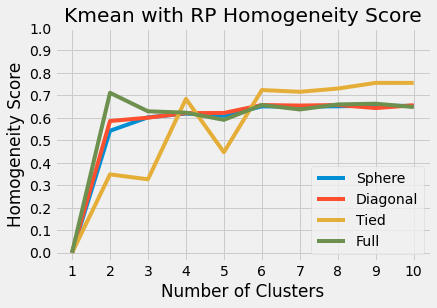

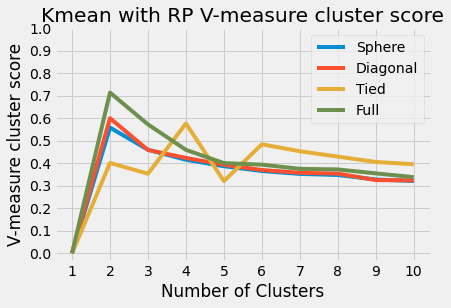

In [44]:
grp = GaussianRandomProjection(n_components=20, random_state=44)
x_prime = grp.fit_transform(data)
gaussianMixtureDataGenerator(x_prime,'Kmean with RP')

In [45]:
#TSVD

C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Nimesh\AppData\Roaming\Python\Python37\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase 

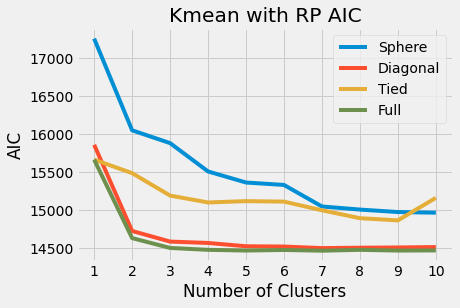

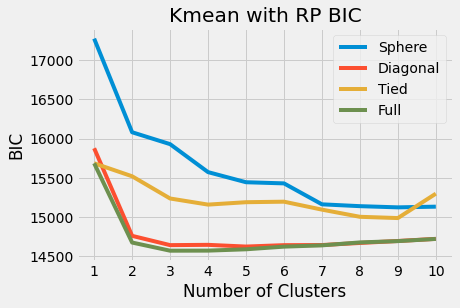

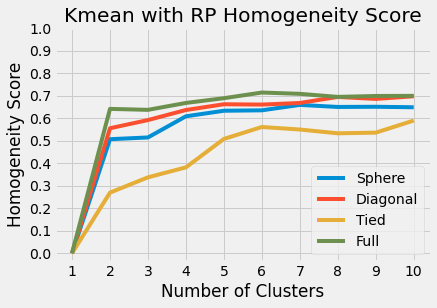

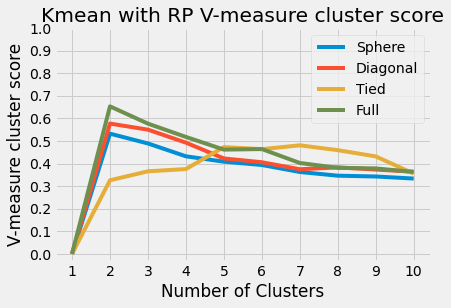

In [46]:
tsvd = TruncatedSVD(2).fit_transform(data)
gaussianMixtureDataGenerator(tsvd,'Kmean with RP')